In [1]:
# prepare notebook

# some common imports
from importlib import reload
from collections import OrderedDict

# import hyptrails
import trails.hyptrails
from trails.hyptrails import *

# numpy 
import numpy as np

# mtmc specific
import trails.transition_probabilities as tp
import trails.randomwalk.randomwalk as rw
import trails.randomwalk.next_state as next_state
import trails.randomwalk.keep_walking as keep_walking
import trails.randomwalk.first_state as first_state
import trails.randomwalk.transition_matrix as tm
import trails.group_assignment as group_assignment
import trails.mtmc.common as common

import trails.utils as utils
import trails.plot as pl
import trails.mtmc.ml.deterministic.default as deterministic

import matplotlib.pyplot as plt

# set default figure size; src: http://txt.arboreus.com/2012/12/13/change-figure-size-in-ipython-notebook-sessions.html
plt.rcParams['figure.figsize'] = 15, 15

# prepare plotting
%matplotlib inline

# Synthetic experiments for MTMC (deterministic)

In [2]:
# experimental setup

# kappa for all experiments
kappa = np.array([0,1,2,3,4,5,10,20,100,1000,10000,100000,1000000])

# smoothing for all experiments
smoothing = 1

## Random graph 

In [3]:
import networkx as nx

# graph constants
n_states = 100
p_state_classes = [0.5, 0.5]

# derived constants
n_state_classes = len(p_state_classes)

# create graph
#graph = nx.fast_gnp_random_graph(n_states, 0.5)
graph = nx.barabasi_albert_graph(n_states, int(n_states * 0.10))

# get adjacency matrix as array
adjacency_matrix = np.asarray(nx.to_numpy_matrix(graph))

# set state classes according to class probabilities
state_class_distribution = np.random.multinomial(n_states, p_state_classes)
state_classes = np.repeat(\
    range(0, n_state_classes), \
    state_class_distribution)

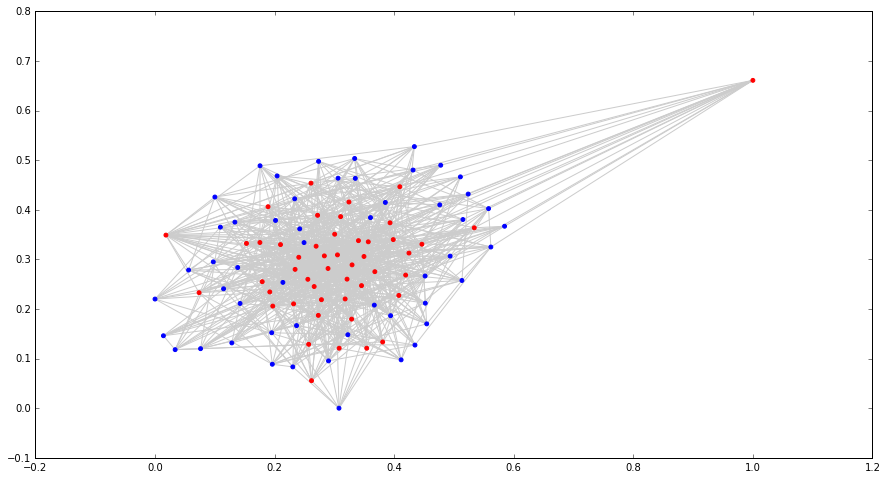

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# visualize graph

colors=['r', 'b', 'g', 'y', 'm', 'c']
state_colors = np.repeat(colors[0:len(p_state_classes)], state_class_distribution)

# nx.draw(graph, node_color=state_colors, font_color='w', with_labels=True, font_weight="bold", arrows=True)
# nx.draw(graph, node_color=state_colors, node_shape="o", node_size=105, linewidths=None, edge_color="#CCCCCC")

pos=nx.spring_layout(graph)
nodes = nx.draw_networkx_nodes(graph,pos, node_color=state_colors, node_size=15) 
nodes.set_edgecolor(state_colors)
edges = nx.draw_networkx_edges(graph,pos,edge_color="#CCCCCC") 
plt.show()

## Transition probability matrices

In [5]:
# transition matrices for walkers

tp_random = tp.random(adjacency_matrix, state_classes)
tp_links = tp.links(adjacency_matrix, state_classes)
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
tp_group_homo_weighted = tp.group_homo_weighted(10, adjacency_matrix, state_classes)

# print("Adjacency matrix")
# print(adjacency_matrix)

# print("\nRandom")
# print(tp_random)

# print("\nLinks")
# print(tp_links)

# print("\nHomo")
# print(tp_group_homo)

# print("\nHomo Weighted (weight=2)")
# print(tp_group_homo_weighted)

## Hypotheses

In [6]:
# hypotheses (single)

hyp_teleport = utils.norm1_2d(np.ones((n_states, n_states)))
hyp_links = utils.norm1_2d(adjacency_matrix)
hyp_red = utils.norm1_2d(tp_group_homo[0])
hyp_blue = utils.norm1_2d(tp_group_homo[1])

# hypotheses (groups)

hyp_groups_homo = tp_group_homo
hyp_groups_homo_weighted = tp_group_homo_weighted

hyp_groups_memory = np.array([hyp_links, hyp_groups_homo[0], hyp_groups_homo[1]])
hyp_groups_memory_weighted = np.array([hyp_links, hyp_groups_homo_weighted[0], hyp_groups_homo_weighted[1]])

# hypotheses (direct)

number_of_groups = [2,3]
hyp_cart_homo_weighted = tp.expand(hyp_groups_homo_weighted, number_of_groups, 0)
hyp_cart_memory_weighted = tp.expand(hyp_groups_memory_weighted, number_of_groups, 1)

hyp_cart_homo = tp.expand(hyp_groups_homo, number_of_groups, 0)
hyp_cart_memory = tp.expand(hyp_groups_memory, number_of_groups, 1)


#print(hyp_groups_homo)
#print(hyp_groups_homo_weighted)
#print(hyp_groups_memory_weighted)
#print(hyp_cart_homo)
#print(hyp_cart_memory)

## Random walks

In [7]:
# random walker constants
n_random_walkers = 10000
n_steps = 10

In [8]:
# next_step functions for different walker types to determine their next move

next_random = next_state.init_matrix(\
        tp_random)

next_links = next_state.init_matrix(\
        tp_links)

next_homo = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo)

next_memory = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo[0], tp_group_homo[1]])

next_homo_weighted = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo_weighted)

next_memory_weighted = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo_weighted[0], tp_group_homo_weighted[1]])

In [9]:
p_random_walker_classes = [0.5, 0.5]
n_random_walker_classes = len(p_random_walker_classes)

# set random walker classes
random_walker_class_counts = \
    np.random.multinomial(n_random_walkers, p_random_walker_classes)
random_walker_classes = np.repeat(
    range(n_random_walker_classes),
    random_walker_class_counts)

In [10]:
# walk the random walks

r = rw.RandomWalk(adjacency_matrix, state_classes)

walks_link = r.walk(
    random_walker_classes,
    next_links,
    keep_walking.init_fixed(n_steps),
    first_state.random)

walks_homo = r.walk(
    random_walker_classes,
    next_homo_weighted,
    keep_walking.init_fixed(n_steps),
    first_state.random)

walks_memory = r.walk(
    random_walker_classes,
    next_memory_weighted,
    keep_walking.init_fixed(n_steps),
    first_state.random)

## Count transitions

In [11]:
transitions_link = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks_link])
transitions_homo = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks_homo])
transitions_memory = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks_memory])

In [12]:
reload(group_assignment)

def calc_group_assignment_p(group_assignment, n_groups):
    p = np.zeros((len(group_assignment), n_groups))
    p[np.arange(p.shape[0]), group_assignment] = 1
    return p

def calc_memory_group_assignment_p(walks_memory, state_properties, n_state_classes):
    
    # calculate groups
    groups = np.concatenate(
        [[group_assignment.memory(walk[0:i+1], None, None, state_properties) 
             for i in range(len(walk) - 1)]
             for walker, walk in walks_memory])
    
    # calculate group assignment probabilitis
    return calc_group_assignment_p(groups, n_state_classes + 1)    
    
walk_sizes = [len(walk) - 1 for walker, walk in walks_link]
link_group_assignment_p_redblue = calc_group_assignment_p(np.repeat(random_walker_classes, walk_sizes), 2)
link_group_assignment_p_memory = calc_memory_group_assignment_p(walks_link, state_classes, n_state_classes)
link_group_assignment_p_random = calc_group_assignment_p(np.random.choice(2, len(transitions_link)), 2)

walk_sizes = [len(walk) - 1 for walker, walk in walks_homo]
homo_group_assignment_p_redblue = calc_group_assignment_p(np.repeat(random_walker_classes, walk_sizes), 2)
homo_group_assignment_p_memory = calc_memory_group_assignment_p(walks_homo, state_classes, n_state_classes)
homo_group_assignment_p_random = calc_group_assignment_p(np.random.choice(2, len(transitions_homo)), 2)

walk_sizes = [len(walk) - 1 for walker, walk in walks_memory]
memory_group_assignment_p_redblue = calc_group_assignment_p(np.repeat(random_walker_classes, walk_sizes), 2)
memory_group_assignment_p_memory = calc_memory_group_assignment_p(walks_memory, state_classes, n_state_classes)
memory_group_assignment_p_random = calc_group_assignment_p(np.random.choice(2, len(transitions_memory)), 2)

## Experiments

In [13]:
# init experiments

kappas_base = [0, 0.001,0.003, 0.01, 0.03, 0.1, 0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000]

In [14]:
def calc_experiments(
        transitions,
        group_assignment_p_redblue,
        group_assignment_p_memory,
        group_assignment_p_random):
    
    
    def exp(group_assignment_p, hyp):
        return { "x": kappas_base, "y": [deterministic.log_ml(
                transitions, 
                group_assignment_p, 
                np.array([a * k for a in hyp]), 
                smoothing= 1) for k in kappas_base]}
    

    experiments = OrderedDict()
    
    # evidences without groups
    experiments["teleport"] = exp(
        np.zeros((len(transitions), 1)),
        np.array([hyp_teleport]))
    experiments["links"] = exp(
        np.zeros((len(transitions), 1)),
        np.array([hyp_links]))
    experiments["red"] = exp(
        np.zeros((len(transitions), 1)),
        np.array([hyp_red]))
    experiments["blue"] = exp(
        np.zeros((len(transitions), 1)), 
        np.array([hyp_blue ]))
    
    # evidences with groups but only a single hypothesis for all groups 
    experiments["red/blue: links"] = exp(
        group_assignment_p_redblue, 
        np.array([hyp_links, hyp_links]))
    experiments["red/blue: red"] = exp(
        group_assignment_p_redblue, 
        np.array([hyp_red, hyp_red]))
    experiments["red/blue: blue"] = exp(
        group_assignment_p_redblue, 
        np.array([hyp_blue, hyp_blue]))
    
    # evidences with groups
    experiments["homo"] = exp(
        group_assignment_p_redblue, 
        hyp_groups_homo)
    experiments["homo (weighted)"] = exp(
        group_assignment_p_redblue, 
        hyp_groups_homo_weighted)
        
    experiments["memory"] = exp(
        group_assignment_p_memory, 
        hyp_groups_memory)
    experiments["memory (weighted)"] = exp(
        group_assignment_p_memory, 
        hyp_groups_memory_weighted)

    return experiments

In [15]:
reload(deterministic)
exp_link = calc_experiments(
    transitions_link,
    link_group_assignment_p_redblue,
    link_group_assignment_p_memory,
    link_group_assignment_p_random)

In [16]:
reload(deterministic)
exp_homo = calc_experiments(
    transitions_homo,
    homo_group_assignment_p_redblue,
    homo_group_assignment_p_memory,
    homo_group_assignment_p_random)

In [17]:
reload(deterministic)
exp_memory = calc_experiments(
    transitions_memory,
    memory_group_assignment_p_redblue,
    memory_group_assignment_p_memory,
    memory_group_assignment_p_random)

## Visualize experiments

In [18]:
# define styles

# cmap = plt.get_cmap("hot", 6)
#def cmap(i):
#    return ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf"][i % 8]
#def cmap(i):
#    return ["red", "green", "blue", "orange"][i % 4]
def cmap(i):
    a = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
    return a[(i) % len(a)]

linewidth=2.5
style = {
    "links": {
        "label": "link", 
        "color": cmap(0), 
        "marker": "o", 
        "linestyle": "--",
        "linewidth":linewidth},
    "red/blue: links": {
        "label": "links-colored", 
        "color": cmap(1), 
        "marker": "^", 
        "linestyle": "-",
        "linewidth":linewidth},
    "homo (weighted)": {
        "label": "color",
        "color": cmap(2), 
        "marker": "d", 
        "linestyle": "-",
        "linewidth":linewidth},
    "memory (weighted)": {
        "label": "memory", 
        "color":  cmap(3), 
        "marker": "s", 
        "linestyle": "-",
        "linewidth":linewidth},
    "cart: links": {
        "label": "links-colored",
        "color": cmap(1), 
        "marker": "^", 
        "linestyle": "-",
        "linewidth":linewidth},
    "cart: homo (weighted)": {
        "label": "color", 
        "color": cmap(2), 
        "marker": "d", 
        "linestyle": "-",
        "linewidth":linewidth},
    "cart: memory (weighted)": {
        "label": "memory", 
        "color": cmap(3), 
        "marker": "s", 
        "linestyle": "-",
        "linewidth":linewidth},
}
size = (2.8,2.8)

In [19]:
keys = [
    "links", 
    "red/blue: links", 
    "homo (weighted)",
    "memory (weighted)"]

In [20]:
from importlib import reload
reload(pl)
fig,ax,leg = pl.plot(exp_link, keys=keys, style=style, notebook=False, xlim=[0.01,1200], ylim=[-400,10], size=(5,4), leg_ncol=4, leg_size=(0.1,0.1))
leg.savefig("out/synthetic-legend.eps", bbox_inches='tight')

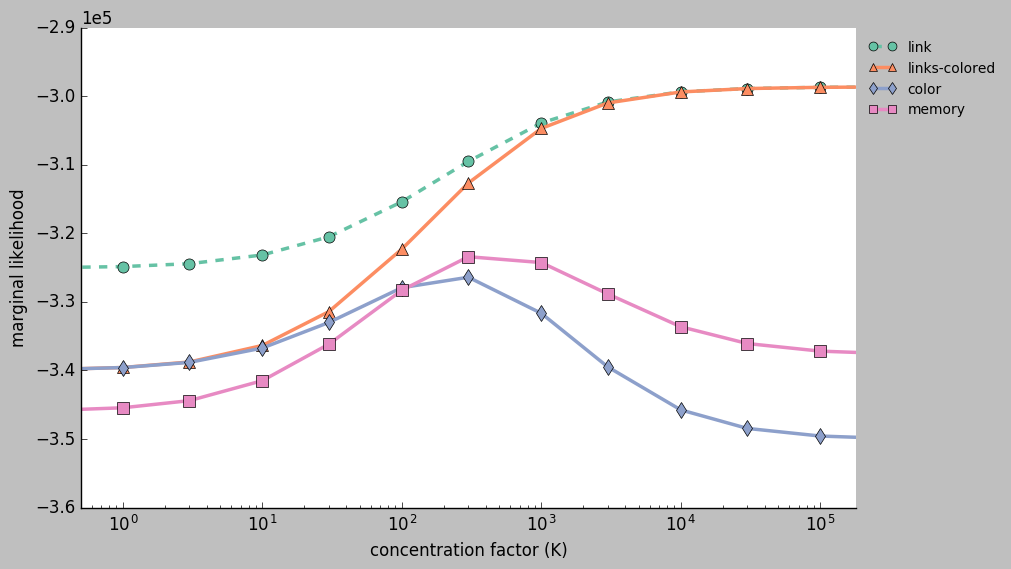

In [21]:
fig, ax, leg = pl.plot(exp_link, keys=keys, style=style, notebook=True, xlim=[.5,180000])
fig, ax, leg = pl.plot(exp_link, keys=keys, style=style, notebook=False, xlim=[.5,180000], axis_labels=True, size=size)
fig.savefig("out/synthetic-links.eps", bbox_inches='tight')

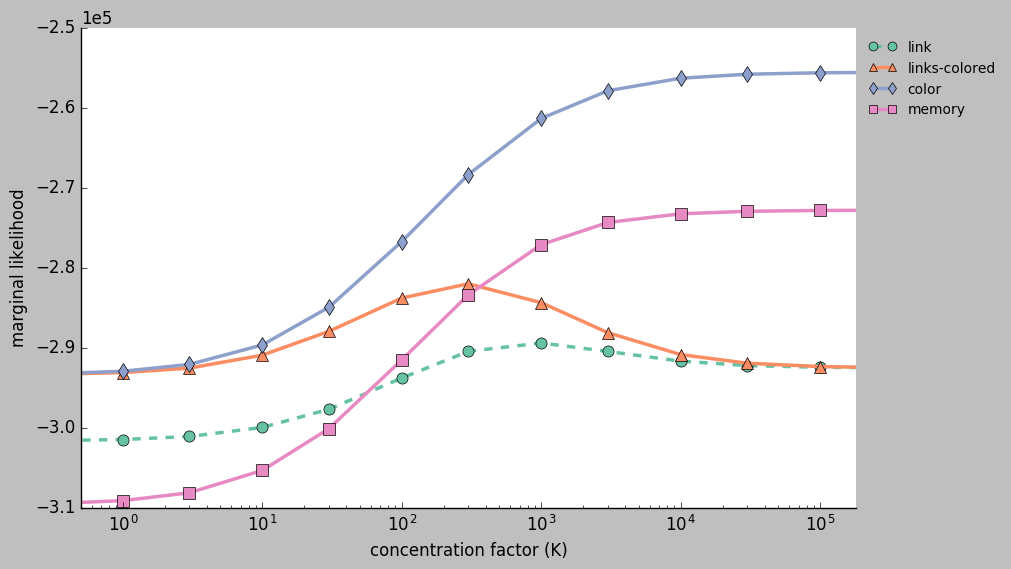

In [22]:
fig, ax, leg = pl.plot(exp_homo, keys=keys, style=style, notebook=True, xlim=[.5,180000])
fig, ax, leg = pl.plot(exp_homo, keys=keys, style=style, notebook=False, xlim=[.5,180000], axis_labels=False, size=size)
fig.savefig("out/synthetic-homo.eps", bbox_inches='tight')

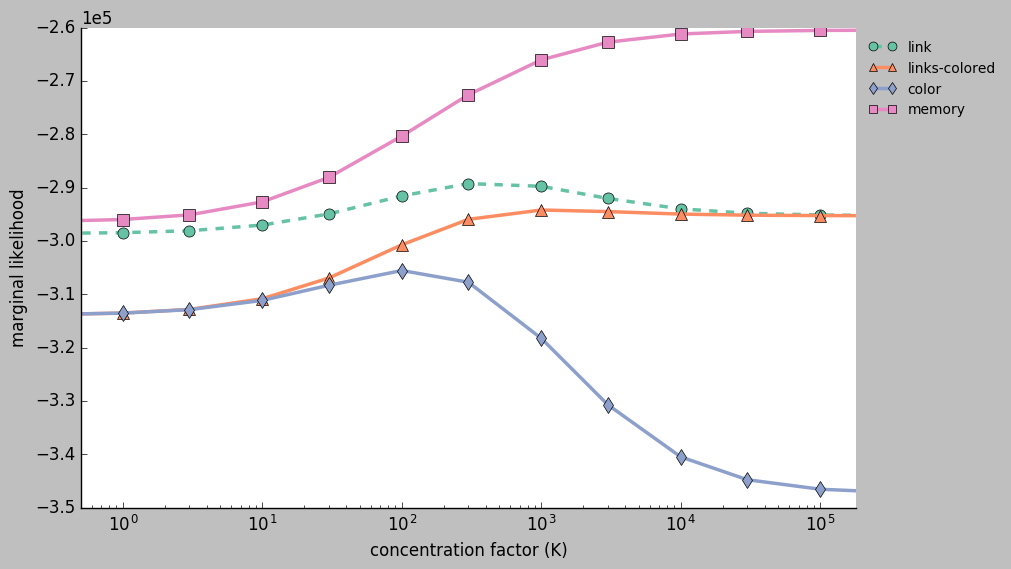

In [23]:
fig, ax, leg = pl.plot(exp_memory, keys=keys, style=style, notebook=True, xlim=[.5,180000])
fig, ax, leg = pl.plot(exp_memory, keys=keys, style=style, notebook=False, xlim=[.5,180000], axis_labels=False, size=size)
fig.savefig("out/synthetic-memory.eps", bbox_inches='tight')

# Synthetic experiments for MTMC (probabilistic/fuzzy)

In [24]:
# violet walkers: we consider violet walkers, where each transition based on the walkers inconsistency
def violet_group(walk, walker, adjacency_matrix, state_properties):
    group = np.random.choice(len(walker), p=walker)
    return group
next_violet = next_state.init_grouped_matrix(violet_group, tp_group_homo_weighted)

In [25]:
# choose the group probabilities for each walker
random_walker_group_dist = np.array([np.random.dirichlet([1,1]) for _ in range(n_random_walkers)])

In [26]:
# Walk the walks

walks_homo_prob = r.walk( 
    random_walker_group_dist, 
    next_violet, 
    keep_walking.init_fixed(n_steps),
    first_state.random)

## Experiment

In [27]:
transitions_prob = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks_homo_prob])
group_assignment_p_prob = np.repeat(random_walker_group_dist, [len(walk) - 1 for walker, walk in walks_homo_prob], axis=0)
group_assignment_p_prob_random = np.repeat(random_walker_group_dist, [len(walk) - 1 for walker, walk in walks_homo_prob], axis=0)

In [28]:
import trails.mtmc.ml.direct.optimized as directo
exp_prob = OrderedDict()

def exp_deterministic(group_assignment_p, hyp):
    return { "x": kappas_base, "y": [deterministic.log_ml(
        transitions_prob, 
        group_assignment_p,
        np.array([a * k for a in hyp]),
        smoothing=1) for k in kappas_base]}

def exp_direct(group_assignment_p, hyp):
    return { "x": kappas_base, "y": [directo.log_ml(
        transitions_prob, 
        group_assignment_p,
        np.array([a * k for a in hyp]),
        smoothing=1,
        n_samples=1) for k in kappas_base]}

In [29]:
# links
exp_prob["links"] = exp_deterministic(
    np.zeros((len(transitions_prob), 1)),
    np.array([hyp_links]))

In [30]:
exp_prob["red/blue: links"] = exp_direct(
        group_assignment_p_prob, 
        common.calc_mixed_hypothesis(group_assignment_p_prob, np.array([ hyp_links, hyp_links ])))
exp_prob["red/blue: links (naive)"] = exp_direct(
        group_assignment_p_prob, 
        np.array([ hyp_links, hyp_links ]))
exp_prob["red/blue: links (max)"] = exp_deterministic(
        group_assignment_p_prob, 
        np.array([ hyp_links, hyp_links ]))

exp_prob["red/blue: red/blue"] = exp_direct(
        group_assignment_p_prob, 
        common.calc_mixed_hypothesis(group_assignment_p_prob, hyp_groups_homo_weighted))
exp_prob["red/blue: red/blue (naive)"] = exp_direct(
        group_assignment_p_prob, 
        hyp_groups_homo_weighted)
exp_prob["red/blue: red/blue (max)"] = exp_deterministic(
        group_assignment_p_prob, 
        hyp_groups_homo_weighted)

In [31]:
# memory hypothesis
group_assignment_p_memory_prob = calc_memory_group_assignment_p(walks_homo_prob, state_classes, n_state_classes)
exp_prob["memory"] = exp_deterministic(
        group_assignment_p_memory_prob, 
        hyp_groups_memory_weighted)

In [32]:
linewidth=2.5
style_prob = {
    "links": {
        "label": "link",
        "color": cmap(0), 
        "marker": "o", 
        "linestyle": "--",
        "linewidth": linewidth
    },
    "red/blue: links": {
        "label": "link-colored, mixed",
        "color": cmap(2), 
        "marker": "^", 
        "linestyle": "-",
        "linewidth": linewidth
    },
    "red/blue: links (naive)": {
        "label": "link-colored",
        "color": cmap(1), 
        "marker": "^", 
        "linestyle": "-",
        "linewidth": linewidth
    },
    "red/blue: red/blue": {
        "label": "violet, mixed",
        "color": cmap(2), 
        "marker": "d",
        "linewidth": linewidth,
        "linestyle": "-"
    },
    "red/blue: red/blue (naive)": {
        "label": "violet, naive",
        "color": cmap(2), 
        "marker": "*", 
        "linestyle": "-",
        "zorder": 20,
        "linewidth": linewidth
    },
    "memory": {
        "label": "memory",
        "color": cmap(3), 
        "marker": "s", 
        "linestyle": "-",
        "zorder": 3,
        "linewidth": linewidth
    },    
}
size = (6,2.8)

In [33]:
keys = ["links", "red/blue: links (naive)", "red/blue: red/blue (naive)", "red/blue: red/blue", "memory"]

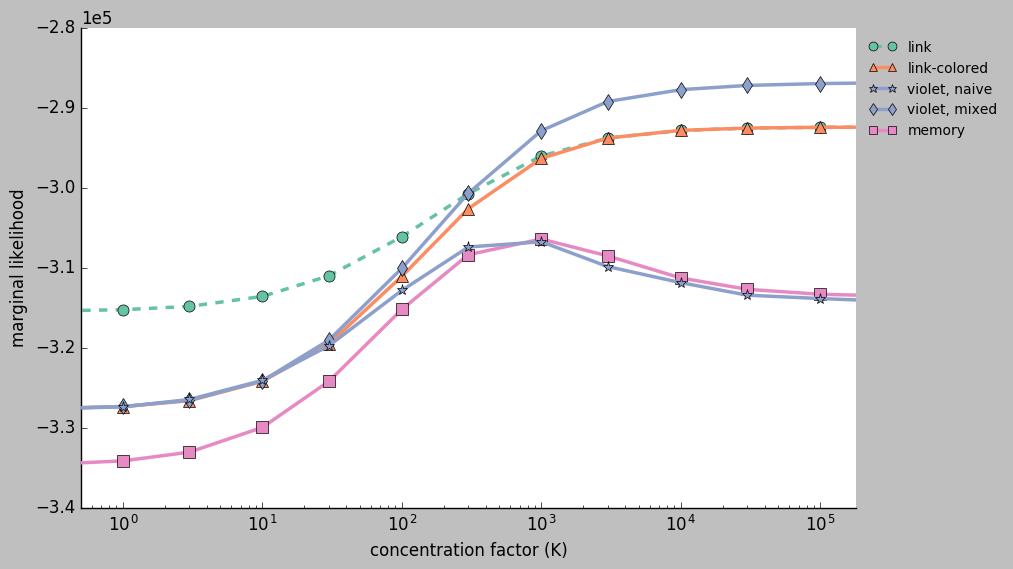

In [34]:
fig, ax, leg = pl.plot(exp_prob, keys=keys, style=style_prob, notebook=True, xlim=[0.5,180000])
fig, ax, leg = pl.plot(exp_prob, keys=keys, style=style_prob, axis_labels=True, notebook=False, xlim=[0.5,180000], size=size, leg_anchor=(0,1), leg_size=(1,2.8))
fig.savefig("out/synthetic-violet.eps", bbox_inches='tight')
leg.savefig("out/synthetic-violet-legend.eps", bbox_inches='tight')